In [1]:
from torchvision.datasets import Flowers102
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # 50% chance to flip image
    transforms.RandomRotation(15),  # Rotate image randomly within ±15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust color properties
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),  # Random crop with scaling
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize pixel values

])
eval_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# Load dataset
train_data = Flowers102(root="data", split="train", transform=transform, download=True)
val_data = Flowers102(root="data", split="val", transform=eval_transform, download=True)
test_data = Flowers102(root="data", split="test", transform=eval_transform, download=True)

# Create DataLoader
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Get a sample
images, labels = next(iter(train_loader))
print(images.shape, labels.shape)

torch.Size([32, 3, 128, 128]) torch.Size([32])


In [3]:
# loading VGG-16
from torchvision.models import vgg16
from torch import nn
import torch
model = vgg16(pretrained=True)

# Access the classifier
classifier = model.classifier

# The final FC layer is the last layer in the classifier
final_fc_layer = classifier[-1]

# Modify the final FC layer to match the number of classes in your dataset
num_classes = 102
final_fc_layer.out_features = num_classes
model.classifier[-1] = nn.Linear(final_fc_layer.in_features, num_classes)

# Freeze all layers except the final linear layer
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last fully connected layer
for param in model.classifier[-1].parameters():
    param.requires_grad = True
    
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device) # using float16

# Example: Forward pass
images, labels = next(iter(train_loader))  # Use train_loader
images = images.to(device)
outputs = model(images)

print(outputs.shape)  # Should be (batch_size, 102)

d:\program_files\anaconda3\envs\torch_gpu\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\program_files\anaconda3\envs\torch_gpu\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([32, 102])


In [4]:
from torchsummary import summary

summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
              ReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3         [-1, 64, 128, 128]          36,928
              ReLU-4         [-1, 64, 128, 128]               0
         MaxPool2d-5           [-1, 64, 64, 64]               0
            Conv2d-6          [-1, 128, 64, 64]          73,856
              ReLU-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
              ReLU-9          [-1, 128, 64, 64]               0
        MaxPool2d-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]         295,168
             ReLU-12          [-1, 256, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         590,080
             ReLU-14          [-1, 256,

In [5]:
from math import inf

class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_acc = -inf  # Start with a very low accuracy
        self.early_stop = False

    def __call__(self, val_acc):
        if self.best_acc is None:
            self.best_acc = val_acc
        elif val_acc - self.best_acc > self.min_delta:  # Accuracy must increase
            self.best_acc = val_acc
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


In [6]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, eps=1e-4)

# Define learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Initialize early stopping
early_stopping = EarlyStopping(patience=5, min_delta=0.001)


d:\program_files\anaconda3\envs\torch_gpu\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
# Lists to store metrics
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

best_val_accuracy = float("inf")  # Initialize with a high value
checkpoint_path = "best_model.pth"  # File to save the best model

# Training loop
for epoch in range(100):  # Set the number of epochs
    print(f"Epoch {epoch+1}/{100}")
    model.train() # sets the model to training model, Drop layers, BatchNorm are active in training mode
    running_loss = 0.0 # total loss
    correct = 0 # total of correct predictions
    total = 0 # number of samples each epoch
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device) # moving features and targets to GPU
        optimizer.zero_grad() # Empty gradients
        outputs = model(inputs) # passing inputs through model
        loss = criterion(outputs, labels) # calculating loss
        loss.backward() #  calculate backpropagating updates
        optimizer.step() # applying updates
        running_loss += loss.item() # accumaliting total loss
        _, predicted = torch.max(outputs, 1) # commonly used to determine classtype, _ is the value, predicted is the index of the maximum
        total += labels.size(0) # accumlating total processed samples 
        correct += (predicted == labels).sum().item() # calculating correctly predicted number

    train_loss = running_loss / len(train_loader) # calculating train loss
    train_accuracy = 100 * correct / total 
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval() # activating evaluation mode, batchnorm and dropouts are deactiavated
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad(): # doesn't calculate gradients
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = running_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Apply learning rate scheduler
    scheduler.step(val_loss)
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Best model saved at epoch {epoch+1} with val_accuracy {val_accuracy:.2f}")
    # Check early stopping
    # early_stopping(val_accuracy)
    # if early_stopping.early_stop:
    #     print(f"Early stopping at epoch {epoch+1}")
    #     break
    
    # Print statistics
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

Epoch 1/100
Epoch 1, Train Loss: 4.0437, Train Accuracy: 13.53%, Val Loss: 2.9803, Val Accuracy: 36.47%
Epoch 2/100
Epoch 2, Train Loss: 1.9366, Train Accuracy: 53.14%, Val Loss: 2.3576, Val Accuracy: 44.80%
Epoch 3/100
Epoch 3, Train Loss: 1.4203, Train Accuracy: 62.45%, Val Loss: 2.1690, Val Accuracy: 45.78%
Epoch 4/100
Epoch 4, Train Loss: 1.1532, Train Accuracy: 70.49%, Val Loss: 2.0372, Val Accuracy: 48.92%
Epoch 5/100
Epoch 5, Train Loss: 0.9786, Train Accuracy: 75.29%, Val Loss: 1.9230, Val Accuracy: 49.90%
Epoch 6/100
Epoch 6, Train Loss: 0.8864, Train Accuracy: 75.29%, Val Loss: 1.9451, Val Accuracy: 48.14%
Epoch 7/100
Epoch 7, Train Loss: 0.8035, Train Accuracy: 77.45%, Val Loss: 1.9188, Val Accuracy: 49.71%
Epoch 8/100
Epoch 8, Train Loss: 0.7650, Train Accuracy: 79.02%, Val Loss: 1.9214, Val Accuracy: 50.29%
Epoch 9/100
Epoch 9, Train Loss: 0.7349, Train Accuracy: 79.51%, Val Loss: 1.8893, Val Accuracy: 50.00%
Epoch 10/100
Epoch 10, Train Loss: 0.6591, Train Accuracy: 80.88

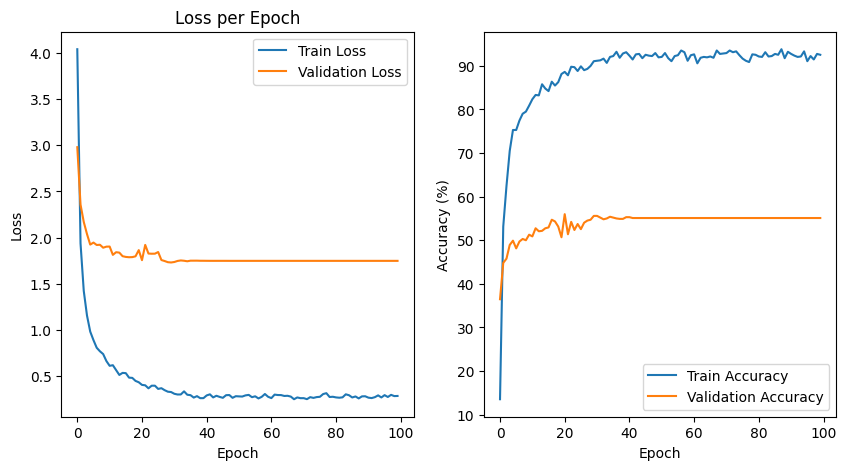

In [8]:
from matplotlib import pyplot as plt
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss per Epoch')

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

In [9]:
# Unfreeze layer -2
for param in model.classifier[-2].parameters():
    param.requires_grad = True

In [13]:

# Define optimizer
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, eps=1e-4)

# Define learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

checkpoint_path = "/best_model_2.pth"

d:\program_files\anaconda3\envs\torch_gpu\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [14]:
# Training loop
for epoch in range(100, 130):  # Set the number of epochs
    print(f"Epoch {epoch+1}/{130}")
    model.train() # sets the model to training model, Drop layers, BatchNorm are active in training mode
    running_loss = 0.0 # total loss
    correct = 0 # total of correct predictions
    total = 0 # number of samples each epoch
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device) # moving features and targets to GPU
        optimizer.zero_grad() # Empty gradients
        outputs = model(inputs) # passing inputs through model
        loss = criterion(outputs, labels) # calculating loss
        loss.backward() #  calculate backpropagating updates
        optimizer.step() # applying updates
        running_loss += loss.item() # accumaliting total loss
        _, predicted = torch.max(outputs, 1) # commonly used to determine classtype, _ is the value, predicted is the index of the maximum
        total += labels.size(0) # accumlating total processed samples 
        correct += (predicted == labels).sum().item() # calculating correctly predicted number

    train_loss = running_loss / len(train_loader) # calculating train loss
    train_accuracy = 100 * correct / total 
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval() # activating evaluation mode, batchnorm and dropouts are deactiavated
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad(): # doesn't calculate gradients
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = running_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Apply learning rate scheduler
    scheduler.step(val_loss)
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Best model saved at epoch {epoch+1} with val_accuracy {val_accuracy:.2f}")

    # Print statistics
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

Epoch 101/130
Epoch 101, Train Loss: 0.3893, Train Accuracy: 87.84%, Val Loss: 1.8358, Val Accuracy: 52.55%
Epoch 102/130
Epoch 102, Train Loss: 0.3534, Train Accuracy: 87.94%, Val Loss: 1.8125, Val Accuracy: 53.33%
Epoch 103/130
Epoch 103, Train Loss: 0.3552, Train Accuracy: 88.04%, Val Loss: 1.8970, Val Accuracy: 52.65%
Epoch 104/130
Epoch 104, Train Loss: 0.3587, Train Accuracy: 89.22%, Val Loss: 1.8961, Val Accuracy: 52.65%
Epoch 105/130
Epoch 105, Train Loss: 0.3096, Train Accuracy: 91.18%, Val Loss: 1.9049, Val Accuracy: 52.55%
Epoch 106/130
Epoch 106, Train Loss: 0.2923, Train Accuracy: 92.06%, Val Loss: 1.9190, Val Accuracy: 52.75%
Epoch 107/130
Epoch 107, Train Loss: 0.3179, Train Accuracy: 90.29%, Val Loss: 1.8892, Val Accuracy: 52.65%
Epoch 108/130
Epoch 108, Train Loss: 0.3504, Train Accuracy: 88.73%, Val Loss: 1.9705, Val Accuracy: 51.76%
Epoch 109/130
Epoch 109, Train Loss: 0.2901, Train Accuracy: 91.67%, Val Loss: 1.9370, Val Accuracy: 52.45%
Epoch 110/130
Epoch 110, Tra

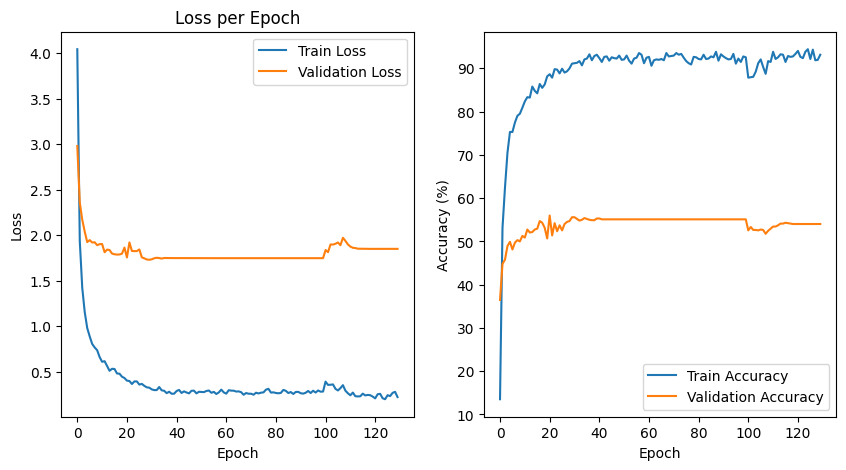

In [15]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss per Epoch')

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()